In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
import datalab_utils
import time

from astropy.coordinates import SkyCoord
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from tqdm import tqdm
from numba import njit

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = "/dlusers/adriansh/work/analyses/plots/strings/"

In [47]:
def count_detections(df, dmag, n, bw, achromatic):
    vals = df["filter"]

    if achromatic:
        indices = [vals[i:i+n].index for i in range(len(vals)- (n - 1)) if len(set(vals[i:i+n])) >= 2]
    else:
        indices = [vals[i:i+n].index for i in range(len(vals)- (n - 1))]

    n_lensed = len(indices)
    detected = [lens_and_detect(df, dmag, idxs, bw) for idxs in indices]
    n_detected = sum(detected)
    oid = df.iloc[0, 0]
    result = pd.DataFrame(data={"lensed": [n_lensed], "detected": [n_detected]}, index=[oid])
    return result

def lens_and_detect(df, dmag, idxs, bw):
    old_vals = df.loc[idxs, "mag_auto"]
    df.loc[idxs, "mag_auto"] = old_vals + dmag
    cl = datalab_utils.cluster_label_dataframe(df, bandwidth=bw)
    df.loc[idxs, "mag_auto"] = old_vals
    result = datalab_utils.lens_filter(cl)
    return result

def calculate_detection_rate(df, delta_mag, n, bandwidth, achromatic=True):
    injection_results = df.groupby(by="objectid", group_keys=False).apply(count_detections, delta_mag, n, bandwidth, achromatic)
    totals = injection_results.sum(axis=0)
    result = totals["detected"] / totals["lensed"]
    return result

@njit
def _find_t_next_other_filter(i, mjds, filters):
    this_filter = filters[i]
    result = np.inf

    for j in range(i + 1, len(mjds)):

        if filters[j] != this_filter:
            result = mjds[j]
            break

    return result

@njit
def _measure_time(t_this, t_floor, t_next_other_filter, taus):
    t = np.maximum(t_floor, t_next_other_filter)
    result = np.maximum(t_this + taus - t, 0)
    return result

@njit
def _compute_t_floor(t_this, taus, t_next_other_filter):
    result = np.maximum(t_this + taus, t_next_other_filter)
    return result

def measure_lensable_time(df, taus):
    filters = df["filter"].values.astype("U1")
    mjds = df["mjd"].values
    t_floor = np.zeros(taus.shape)
    result = np.zeros(taus.shape)

    for i in range(len(df)):
        t_this = mjds[i]
        t_next_other_filter = _find_t_next_other_filter(i, mjds, filters)

        if np.isfinite(t_next_other_filter):
            result += _measure_time(t_this, t_floor, t_next_other_filter, taus)
        else:
            break

        t_floor = _compute_t_floor(t_this, taus, t_next_other_filter)

    return result

In [3]:
lmc_center = SkyCoord("05h23m34s", "−69d45.4m")
lmc_ra = lmc_center.ra.deg
lmc_dec = lmc_center.dec.deg
search_radius = 15
n_detections = 10
sigma_cutoff = 0.1

In [7]:
mask_filter = lc["filter"] == lc["filter"].iat[0]
mask_forward = np.full(len(lc), True)
mask_forward[0] = False

In [12]:
%timeit lc.loc[(~mask_filter) & mask_forward, "mjd"].iat[0]
%timeit lc.loc[(~mask_filter) & mask_forward, "mjd"].min()

374 µs ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
396 µs ± 7.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [104]:
taus = np.arange(10, 510, 10).reshape(1, -1)
%timeit measure_lensable_time(lc, taus)

13.7 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
oq = f"""
SELECT id 
    FROM nsc_dr2.object
        WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
        AND class_star > 0.9
        AND
        (CASE 
            WHEN ndetu > {n_detections} 
            AND urms < {sigma_cutoff} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetg > {n_detections} 
            AND grms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetr > {n_detections} 
            AND rrms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndeti > {n_detections} 
            AND irms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetz > {n_detections} 
            AND zrms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetY > {n_detections} 
            AND Yrms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END >= 3)
"""

qc.query(sql=oq, out="mydb://temp", timeout=1200)

'OK'

In [11]:
qq = f"""
SELECT ROW_NUMBER() OVER() - 1 AS row_number, id
    FROM mydb://temp
"""

qc.query(sql=qq, out="mydb://stable_lmc_ids2", timeout=1200)

'OK'

In [4]:
# bw = 0.11
# batch_size = int(1e5)
# n_objects = 6619504
# num_batches = int(n_objects / batch_size) + 1
# poll_rate = 60
# batch_nums = np.arange(0, num_batches)
min_num_detections = 3

sub_query = f"""
SELECT id
    FROM mydb://stable_lmc_ids2
    WHERE row_number = 0
"""
#     ORDER BY RANDOM()
#     LIMIT 100

query = f"""
SELECT m.objectid, m.filter, m.mag_auto, m.magerr_auto, m.mjd, m.exposure, e.exptime
    FROM nsc_dr2.meas AS m
    INNER JOIN nsc_dr2.exposure AS e
    ON e.exposure = m.exposure
    WHERE m.objectid IN ({sub_query})
"""
lc = qc.query(sql=query, fmt="pandas", timeout=1200)
lc = lc.groupby(by=["objectid", "filter"]).filter(lambda x: len(x) >= min_num_detections)
lc.sort_values(by="mjd", inplace=True)

In [78]:
def foo(lc):
    taus = np.arange(10, 30, 10)
    t_step = 1e-3
    mjds = lc.pivot(columns="filter", values="mjd").round(3)
    min_mjd = lc["mjd"].round(3).min()
    max_mjd = lc["mjd"].round(3).max()
    times = np.array([np.linspace(min_mjd, max_mjd + tau, num=int(1e5)) for tau in taus])
    times = times.reshape((times.shape[0], times.shape[1], 1))
    taus = taus.reshape((len(taus), 1, 1))
    filter_windows = []

    for col in mjds.columns:
        t_samples = mjds[col].dropna().values
        t_samples = t_samples.reshape((1, 1, t_samples.size))
        windows = (np.heaviside(times - t_samples, 1) * np.heaviside(taus - (times - t_samples), 1)).sum(axis=2)
#         filter_windows.append(windows)

#     filter_windows = np.array(filter_windows

#     for time in times:
#         mask = (lc["mjd"] <= time) & (lc["mjd"] >= time - tau)
#         filters = lc.loc[mask, "filter"].unique()
#         if len(filters) > 1:
#             result.append(time)

#     result = [np.meshgrid(times, taus, mjds[col].dropna().values) for col in mjds.columns[:1]]
    
#     y = np.array([[sum([np.heaviside(t_range - t0, 1) * np.heaviside(tau - (t_range - t0), 1)
#                         for t0 in mjds[col].dropna()])
#                    for col in mjds.columns] for tau in taus])
#     row_idxs = np.nonzero((y > 0).sum(axis=1) > 1)[0]
#     result = np.unique(row_idxs, return_counts=True)[1] * t_step
    return filter_windows

In [16]:
a = np.arange(10).reshape((10, 1, 1))
b = np.arange(100).reshape((10, 10, 1))
c = np.arange(8).reshape((1, 1, 8))
(a * b * c).shape

(10, 10, 8)

In [129]:
mjds = lc.sort_values(by="filter").pivot(columns="filter", values="mjd").round(3).fillna(np.inf).values
finite = np.isfinite(mjds)

In [39]:
import cProfile
cProfile.run("foo(lc)", "foostats")

In [42]:
x=np.ones((100, 100, 100))
%timeit x.sum(axis=0)
%timeit x.sum(axis=1)
%timeit x.sum(axis=2)

406 µs ± 5.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
449 µs ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
580 µs ± 4.93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [80]:
315856841e-9

0.315856841

In [79]:
from line_profiler import LineProfiler

profiler = LineProfiler()
profiler.add_function(foo)
profiler_wrapper = profiler(foo)
profiler_wrapper(lc)  # Run the function
profiler.print_stats()  # Print the profiling

Timer unit: 1e-09 s

Total time: 0.341958 s
File: <ipython-input-78-c1f00587b155>
Function: foo at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def foo(lc):
     2         1      37091.0  37091.0      0.0      taus = np.arange(10, 30, 10)
     3         1        823.0    823.0      0.0      t_step = 1e-3
     4         1   15490550.0    2e+07      4.5      mjds = lc.sort_values(by="filter").pivot(columns="filter", values="mjd").round(3)
     5         1     555060.0 555060.0      0.2      min_mjd = lc["mjd"].round(3).min()
     6         1     519411.0 519411.0      0.2      max_mjd = lc["mjd"].round(3).max()
     7         1    4110740.0    4e+06      1.2      times = np.array([np.linspace(min_mjd, max_mjd + tau, num=int(1e5)) for tau in taus])
     8         1       7675.0   7675.0      0.0      times = times.reshape((times.shape[0], times.shape[1], 1))
     9         1       3254.0   3254.0      0.0      taus

In [40]:
import pstats
p = pstats.Stats('foostats')
p.sort_stats("cumtime").print_stats(50)

Wed Jun  5 15:32:51 2024    foostats

         12973 function calls (12701 primitive calls) in 0.351 seconds

   Ordered by: cumulative time
   List reduced from 529 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.351    0.351 {built-in method builtins.exec}
        1    0.000    0.000    0.351    0.351 <string>:1(<module>)
        1    0.299    0.299    0.351    0.351 <ipython-input-38-38809f8863cd>:1(foo)
       30    0.029    0.001    0.029    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        5    0.000    0.000    0.029    0.006 {method 'sum' of 'numpy.ndarray' objects}
        5    0.000    0.000    0.029    0.006 /home/jail/dlusers/adriansh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:46(_sum)
        1    0.000    0.000    0.007    0.007 /home/jail/dlusers/adriansh/.local/lib/python3.8/site-packages/pandas/core/frame.py:5918(pivot)
        1    0.000    0.000    0.007    0

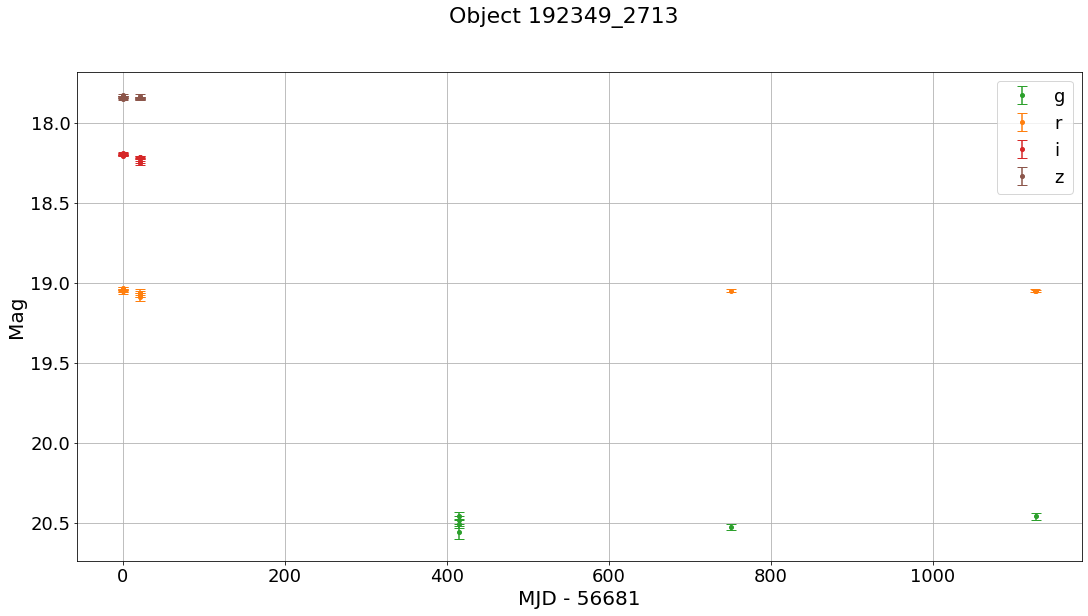

In [80]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown"])
filters = np.array(['u', 'g', 'r', 'i', 'z'])

fig, ax = plt.subplots(1, 1, figsize=(18, 9))
min_mjd = int(lc["mjd"].min())

for f, c in zip(filters, colors):
    m_f = lc["filter"] == f
    lc_full = lc.loc[m_f]

    if len(lc_full) > 0:
        ax.errorbar(lc_full["mjd"] - min_mjd, lc_full['mag_auto'], 
                    yerr=lc_full["magerr_auto"], marker='.', ms=8,
                    capsize=5, color=c, ls="None", label=f)

ax.set_ylabel('Mag', fontsize=20)
ax.tick_params(labelsize=18)
ax.invert_yaxis()
ax.grid(visible=True)
legend = ax.legend(fontsize=18, loc="upper right")
ax.set_xlabel(f'MJD - {min_mjd}', fontsize=20)
fig.suptitle(f"Object {lc.iloc[0, 0]}", fontsize=22)
# ax.set_xlim((740, 760))

plt.show(fig)
fig.savefig(f"{fig_dir}{lc.iloc[0, 0]}_lightcurve.png")
plt.close(fig)

In [5]:
delta_mags = -np.linspace(0.1, 2.5, num=25)

In [6]:
achromatic_rates2 = np.array([calculate_detection_rate(lc, dmag, 2, 0.11, achromatic=True) for dmag in tqdm(delta_mags)])
# chromatic_rates2 = np.array([calculate_detection_rate(lc, dmag, 2, bw, achromatic=False) for dmag in tqdm(delta_mags)])

 12%|█▏        | 3/25 [15:59<1:57:11, 319.63s/it]

KeyboardInterrupt: 

In [ ]:
detection_rates_n3 = np.array([calculate_detection_rate(lc, dmag, 3, bw) for dmag in delta_mags])

In [26]:
# sums = detection_rates.sum(axis=1)
# detection_rates = sums[:, 1] / sums[:, 0]
stair_edges = np.concatenate(([0], delta_mags))

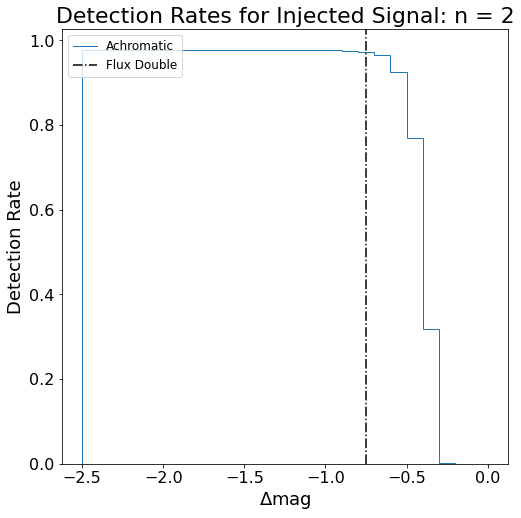

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.stairs(achromatic_rates2, edges=stair_edges, label="Achromatic")
# ax.stairs(chromatic_rates2, edges=stair_edges, label="Chromatic")
ax.set_title("Detection Rates for Injected Signal: n = 2", fontsize=22)
ax.set_ylabel("Detection Rate", fontsize=18)
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
# ax.axvspan(-2.5 * np.log10(2.3), -2.5 * np.log10(1.7), alpha=0.2, 
#            color="tab:gray", label="Default Passband")
ax.axvline(-2.5 * np.log10(2), color='k', ls="-.", label="Flux Double")
ax.legend(loc="upper left", fontsize=12)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}detection_rate_bw0-1_n2.png")
plt.show(fig)

In [7]:
bandwidths = 2.5 * np.log10(2) * np.linspace(1/20, 1/4, num=21)
pass_percentage = []

for b in tqdm(bandwidths):
    cl = datalab_utils.cluster_label_dataframe(lc, bandwidth=b)
    stable = cl.groupby(by=["objectid", "filter"]).apply(lambda x: (x["cluster_label"] == 1).all())
    pass_percentage.append(stable.sum() / len(stable))


100%|██████████| 21/21 [02:22<00:00,  6.78s/it]


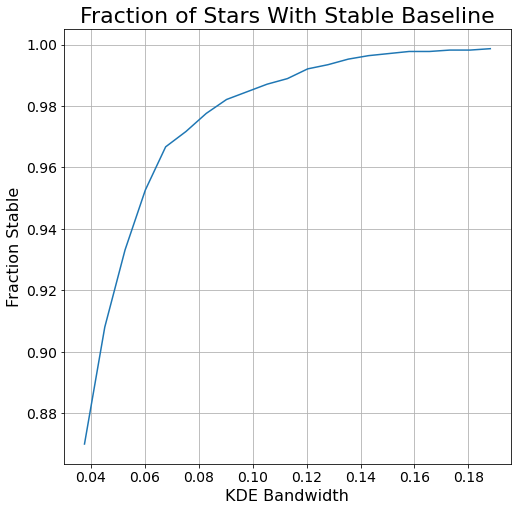

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(bandwidths, pass_percentage)
ax.set_xlabel("KDE Bandwidth", fontsize=16)
ax.set_ylabel("Fraction Stable", fontsize=16)
ax.set_title("Fraction of Stars With Stable Baseline", fontsize=22)
ax.tick_params(labelsize=14)
ax.grid(visible=True)
# fig.savefig(f"{fig_dir}fraction_stable_v_bandwith.png")
plt.show(fig)

In [9]:
rates_bw = np.array([calculate_detection_rate(lc, -2.5 * np.log10(2), 2, b, achromatic=True) for b in tqdm(bandwidths)])


100%|██████████| 21/21 [1:56:09<00:00, 331.88s/it]


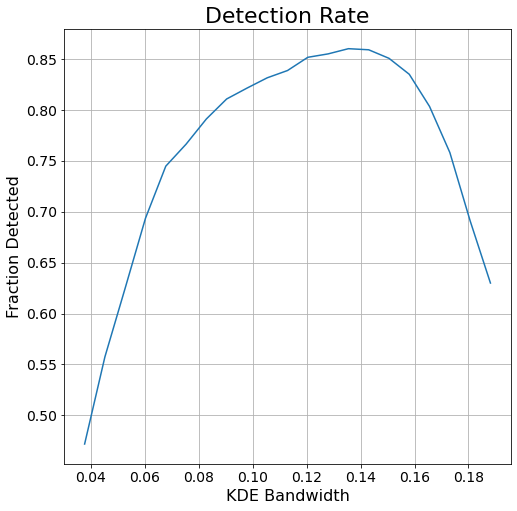

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(bandwidths, rates_bw)
ax.set_xlabel("KDE Bandwidth", fontsize=16)
ax.set_ylabel("Fraction Detected", fontsize=16)
ax.set_title("Detection Rate", fontsize=22)
ax.tick_params(labelsize=14)
ax.grid(visible=True)
# fig.savefig(f"{fig_dir}detection_rate_v_bandwidth_flux_double.png")
plt.show(fig)

In [32]:
import importlib
importlib.reload(datalab_utils)
calculate_detection_rate(lc, -2.5 * np.log10(2), 2, 0.11, achromatic=True)

0.8640305237599722

In [37]:
wstds = lc.groupby(by=["objectid", "filter"]).apply(lambda x: datalab_utils.weighted_std(x["mag_auto"].values, x["magerr_auto"].values**-2))

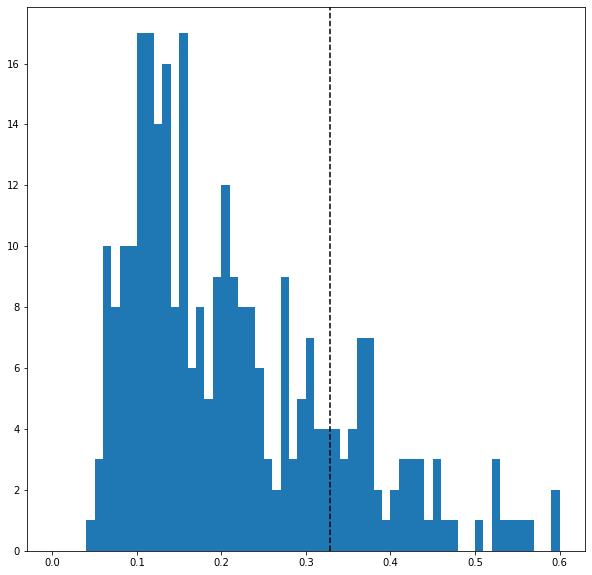

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
std_bins = np.linspace(0, .6, num=61)
ax.hist(10 * wstds, bins=std_bins)
ax.axvline(2.5 * np.log10(2.3 / 1.7), color='k', ls="--")
plt.show(fig)

In [42]:
bandwidths[10]

0.11288624837399297

In [41]:
injection_results = lc.groupby(by="objectid", group_keys=False).apply(count_detections, -2.5, 2, bw, achromatic=False)

KeyboardInterrupt: 

In [ ]:
injection_results["rate"] = injection_results["detected"] / injection_results["lensed"]

In [ ]:
oids = lc["objectid"].unique()[:10]

In [ ]:
t = datalab_utils.subtract_baseline(datalab_utils.cluster_label_dataframe(lc, bandwidth=bw))

In [83]:
lc = t

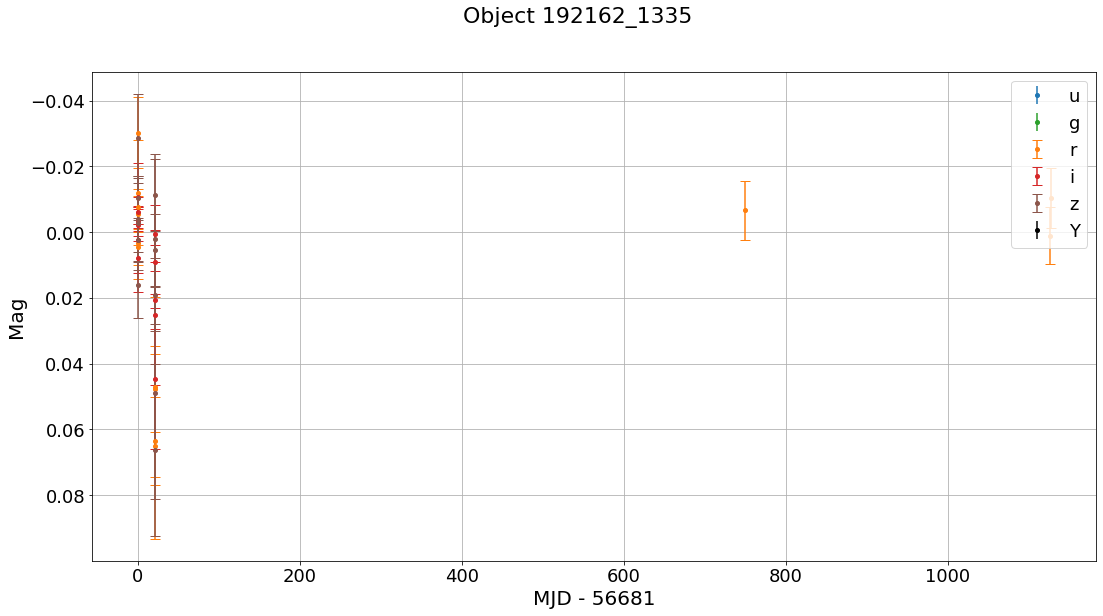

In [105]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", 'k'])
filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])

for oid in oids[:1]:
    m_id = lc["objectid"] == oid
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    min_mjd = int(lc.loc[m_id, "mjd"].min())

    for f, c in zip(filters, colors):
        m_f = lc["filter"] == f
        lc_f = lc.loc[m_id & m_f]

        ax.errorbar(lc_f["mjd"] - min_mjd, lc_f['delta_mag'], 
                    yerr=lc_f["magerr_auto"], marker='.', ms=8,
                    capsize=5, color=c, ls="None", label=f)

    ax.set_ylabel('Mag', fontsize=20)
    ax.tick_params(labelsize=18)
    ax.invert_yaxis()
    ax.grid(visible=True)
    # ax.axhline(-2.5 * np.log10(2), color='k', linestyle="-.")

    legend = ax.legend(fontsize=18, loc="upper right")
    ax.set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    fig.suptitle(f"Object {oid}", fontsize=22)
    plt.show(fig)
    fig.savefig(f"{fig_dir}{oid}_lightcurve_baseline_subtracted.png")
    plt.close(fig)

In [95]:
import importlib
importlib.reload(datalab_utils)
df = lc.loc[lc["objectid"] == oids[0]].copy()
idxs = df.index
lens_and_detect(df, -.5, idxs[0:2], bw/2)

2
True True True
1
1


True

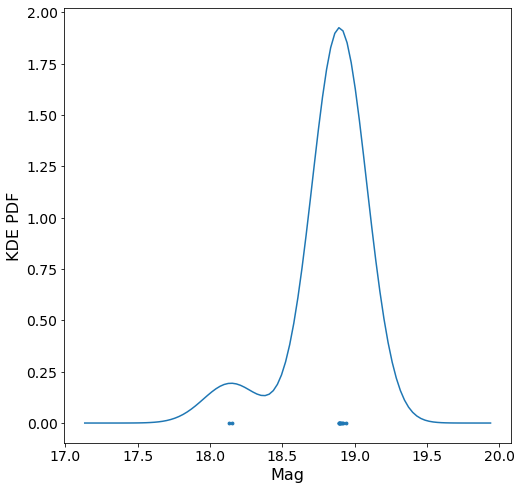

In [113]:
from scipy.stats import gaussian_kde

samples = df.loc[df["filter"] == 'i', "mag_auto"].values
weights = df.loc[df["filter"] == 'i', "magerr_auto"].values**-2
samples[:2] -= 0.75
kde = gaussian_kde(samples, bw_method=1, weights=weights)
kde.set_bandwidth(bw / np.sqrt(kde.covariance[0, 0]))
x = np.linspace(samples.min() - 1, samples.max() + 1, num=100)
pdf = kde(x)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, pdf)
ax.scatter(samples, np.zeros(samples.shape), s=8)
ax.set_xlabel("Mag", fontsize=16)
ax.set_ylabel("KDE PDF", fontsize=16)
ax.tick_params(labelsize=14)
plt.show(fig)
fig.savefig(f"{fig_dir}kde_example_075.png")
plt.close(fig)

In [9]:
detection_rates_3 = np.array([calculate_detection_rate(lc, pass_percentage bw) for dmag in delta_mags])

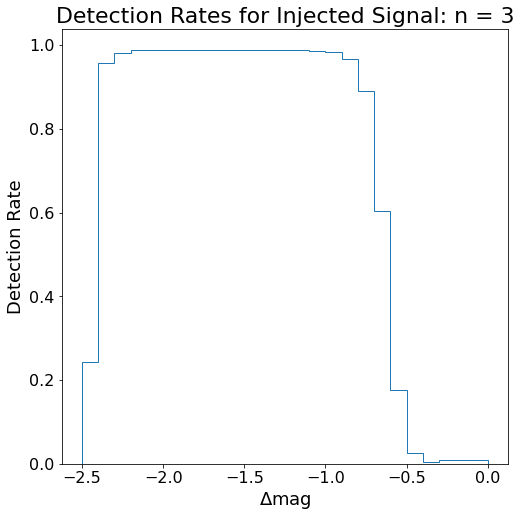

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.stairs(detection_rates_3, edges=stair_edges)
ax.set_title(f"Detection Rates for Injected Signal: n = 3", fontsize=22)
ax.set_ylabel("Detection Rate", fontsize=18)
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}detection_rate_n3.png")
plt.show(fig)